In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import gc

import datetime

from config import (
    RAW_DATA_DIR
)

import matplotlib.pyplot as plt

-------------------------------------------------------------
configurations: 
{
  "storeId": null,
  "influence_sheet": "",
  "influence_min": 0,
  "influence_max": 0,
  "predict_start_date": "2019-06-23",
  "predict_length": 35,
  "lag_length": 50,
  "lag_cols": [
    "Sales"
  ],
  "sliding_window_length": 50,
  "sliding_cols": [
    "Sales"
  ],
  "model_list": [
    "LGBMRegressor"
  ],
  "peak_period": [
    "2017-12-08",
    "2018-02-08",
    "2018-12-10",
    "2019-02-10"
  ]
}
-------------------------------------------------------------


/Users/liuyu/Desktop/g-forecast/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [64]:
holidays_events_df = pd.read_csv(RAW_DATA_DIR+'holidays_events.csv')
items_df = pd.read_csv(RAW_DATA_DIR+'items.csv')
oil_df = pd.read_csv(RAW_DATA_DIR+'oil.csv',parse_dates=['date'])
stores_df = pd.read_csv(RAW_DATA_DIR+'stores.csv')
transactions_df = pd.read_csv(RAW_DATA_DIR+'transactions.csv')

# train_df = pd.read_csv(RAW_DATA_DIR+'train.csv')

In [73]:
train_df = pd.read_csv(
    'datasets/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

In [74]:
tmp = train_df[train_df['date']>datetime.date(2017, 1, 1)]

/Users/liuyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [72]:
t = pd.read_csv(RAW_DATA_DIR+'test.csv')

In [75]:
t_l = t.item_nbr.unique()
tr_l = train_df.item_nbr.unique()

In [89]:
c = 0
a = 0

In [90]:
for i in t_l:
    if i not in tr_l:
#         print(i)
        c+=1
    a+1

In [91]:
'{}/{}'.format(c, len(t_l))

'60/3901'

In [92]:
60/3901

0.015380671622660855

In [45]:
tmp.head(1)

,date,store_nbr,item_nbr,unit_sales,onpromotion
35231564,2017-01-02,1,103520,0.693147,False


In [65]:
t = tmp.merge(oil_df, on = 'date')

In [7]:
test_s_l = test_df.store_nbr.unique()

In [9]:
test_s_l.shape

(54,)

In [10]:
train_s_l = train_df.store_nbr.unique()

In [11]:
train_s_l.shape

(54,)

In [30]:
c = 0
for i in test_s_l:
    train_i_l = train_df[train_df['store_nbr']==i].item_nbr.unique()
    test_i_l = test_df[test_df['store_nbr']==i].item_nbr.unique()
    count = 0
    for item in test_i_l:
        if item not in train_i_l:
            count+=1
            c +=1
    print('store {}, count {}/{}'.format(i, count, train_i_l.shape[0]))
    print('test len {}'.format(test_i_l.shape[0]))
print('total {}'.format(c))

store 1, count 538/3540
test len 3901
store 2, count 520/3561
test len 3901
store 3, count 461/3623
test len 3901
store 4, count 585/3492
test len 3901
store 5, count 588/3490
test len 3901
store 6, count 524/3559
test len 3901
store 7, count 488/3594
test len 3901
store 8, count 449/3634
test len 3901
store 9, count 892/3163
test len 3901
store 10, count 1467/2550
test len 3901
store 11, count 950/3101
test len 3901
store 12, count 1430/2592
test len 3901
store 13, count 1536/2480
test len 3901
store 14, count 1469/2542
test len 3901
store 15, count 1389/2630
test len 3901
store 16, count 1423/2597
test len 3901
store 17, count 1292/2737
test len 3901
store 18, count 868/3185
test len 3901
store 19, count 1443/2570
test len 3901
store 20, count 933/3121
test len 3901
store 21, count 962/3092
test len 3901
store 22, count 1375/2644
test len 3901
store 23, count 658/3407
test len 3901
store 24, count 527/3554
test len 3901
store 25, count 589/3488
test len 3901
store 26, count 705/3359


## IMPORTANT

In test.csv, it tries to ask us to predict new items. 

So we train 2 separate models: one for old items. One for new item.


In [20]:
train_df.date.max()

Timestamp('2017-08-15 00:00:00')

In [21]:
tmp = train_df[train_df['date']==train_df.date.max()]

In [25]:
tmp.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
58935320,2017-08-15,1,103665,0.693147,False
58935321,2017-08-15,1,105574,1.609438,False
58935322,2017-08-15,1,105575,2.197225,False
58935323,2017-08-15,1,105577,1.098612,False
58935324,2017-08-15,1,105693,0.693147,False


In [26]:
103501 in tmp.item_nbr.unique()

True

In [27]:
tmp[tmp['item_nbr']==103501]

,date,store_nbr,item_nbr,unit_sales,onpromotion
58952883,2017-08-15,9,103501,2.079442,False
58955048,2017-08-15,10,103501,1.609438,False
58956411,2017-08-15,11,103501,1.098612,False
58959882,2017-08-15,13,103501,0.693147,False
58961188,2017-08-15,14,103501,1.386294,False
58962577,2017-08-15,15,103501,1.098612,False
58964078,2017-08-15,16,103501,0.693147,False
58965407,2017-08-15,17,103501,1.098612,False
58967171,2017-08-15,18,103501,0.693147,False
58969069,2017-08-15,19,103501,1.609438,False


In [28]:
test_df[test_df['date']==test_df['date'].min()][test_df['item_nbr']==103501]

/Users/liuyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,date,store_nbr,item_nbr,onpromotion
2,125497042,2017-08-16,1,103501,False
3903,125500943,2017-08-16,2,103501,False
7804,125504844,2017-08-16,3,103501,False
11705,125508745,2017-08-16,4,103501,False
15606,125512646,2017-08-16,5,103501,False
19507,125516547,2017-08-16,6,103501,False
23408,125520448,2017-08-16,7,103501,False
27309,125524349,2017-08-16,8,103501,False
31210,125528250,2017-08-16,9,103501,False
35111,125532151,2017-08-16,10,103501,False


In [18]:
103501 in train_i_l

False

In [19]:
103501 in test_i_l

True

In [23]:
profile = pandas_profiling.ProfileReport(train_df)
profile

Number of variables,6
Number of observations,125497040
Total Missing (%),2.9%
Total size in memory,5.6 GiB
Average record size in memory,48.0 B
Numeric,4
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [25]:
profile.to_file("train_analysis.html")

In [26]:
del profile

In [28]:
gc.collect()

7499

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
id             int64
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


In [2]:
test_df = pd.read_csv(RAW_DATA_DIR + 'test.csv')

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
id             int64
date           object
store_nbr      int64
item_nbr       int64
onpromotion    bool
dtypes: bool(1), int64(3), object(1)
memory usage: 106.1+ MB


In [134]:
test_df.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [36]:
train_store_list = train_df.store_nbr.unique()
test_store_list = test_df.store_nbr.unique()

In [48]:
len(test_item_list)

3901

In [50]:
# check whether there is useless data.

useless_data_dict = {}
for storeId in train_store_list:
    useless_data_dict[storeId] = []
    if storeId not in test_store_list:
        print(storeId)
    train_item_list = train_df[train_df['store_nbr']==storeId].item_nbr.unique()
    test_item_list= test_df[test_df['store_nbr']==storeId].item_nbr.unique()
    for item in train_item_list:
        if item not in test_item_list:
            useless_data_dict[storeId].append(item)


In [54]:
test_df.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [55]:
test_df.date.unique()

array(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
       '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
       '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype=object)

predict from 2017-08-16 to 2017-08-31. 16 days in total.

In [91]:
store1 = train_df[train_df['store_nbr']==1]

In [92]:
store1.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
578,578,2013-01-02,1,103665,2.0,NaN
579,579,2013-01-02,1,105574,8.0,NaN
580,580,2013-01-02,1,105575,15.0,NaN
581,581,2013-01-02,1,105577,2.0,NaN
582,582,2013-01-02,1,105737,2.0,NaN


In [93]:
store1.date = pd.to_datetime(store1.date)

/Users/liuyu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [94]:
store1 = store1[store1['date']>datetime.date(2017,1,1)]

/Users/liuyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [96]:
store1.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
101690472,101690472,2017-01-02,1,103520,1.0,False
101690473,101690473,2017-01-02,1,105575,3.0,False
101690474,101690474,2017-01-02,1,105577,1.0,False
101690475,101690475,2017-01-02,1,105737,1.0,False
101690476,101690476,2017-01-02,1,108079,2.0,False


In [97]:
store1.groupby('item_nbr').count().sort_values('id', ascending=False).head(3)

,id,date,store_nbr,unit_sales,onpromotion
item_nbr,,,,,
841197,226,226,226,226,226
1473482,226,226,226,226,226
305080,226,226,226,226,226


In [98]:
store1 = store1[store1['item_nbr']==1473482]

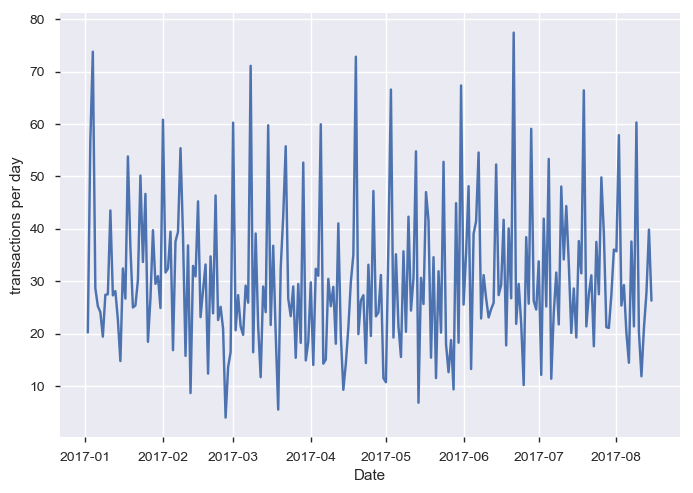

In [99]:
plt.style.use('seaborn-deep')
# plt.figure(figsize=(13,11))
plt.plot(store1.date.values, store1.unit_sales)
# plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

In [100]:
store1['weekday'] = store1.date.dt.weekday

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a5e77f0>,
      dtype=object)

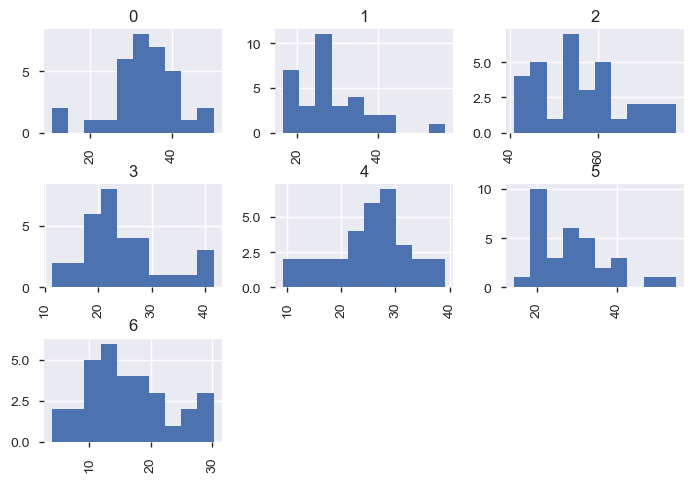

In [101]:
store1[['weekday', 'unit_sales']].hist('unit_sales', 'weekday')

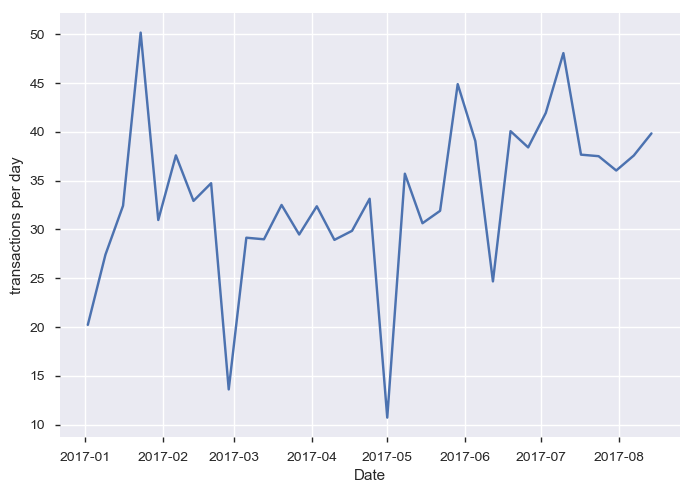

In [103]:
tmp = store1[store1['weekday'] == 0]
plt.style.use('seaborn-deep')
# plt.figure(figsize=(13,11))
plt.plot(tmp.date.values, tmp.unit_sales)
# plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

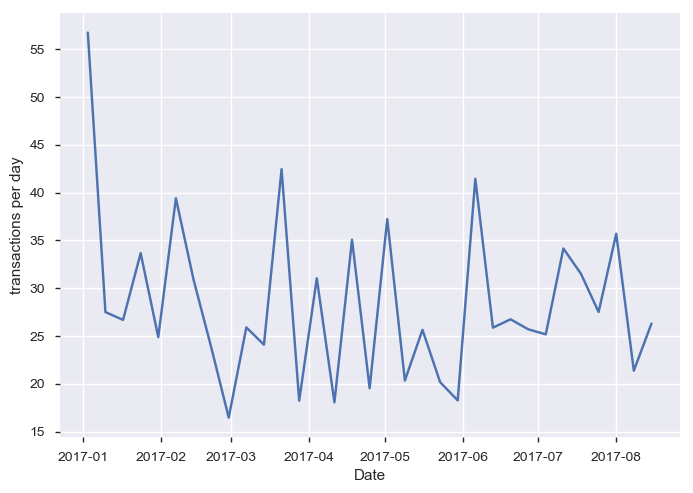

In [104]:
tmp = store1[store1['weekday'] == 1]
plt.style.use('seaborn-deep')
# plt.figure(figsize=(13,11))
plt.plot(tmp.date.values, tmp.unit_sales)
# plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

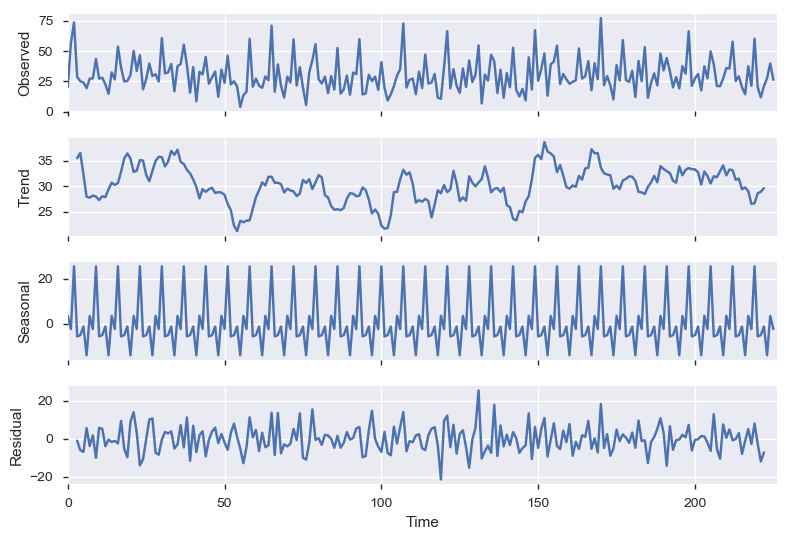

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(store1['unit_sales'].values, model='additive', freq = 7)
result.plot()
plt.show()

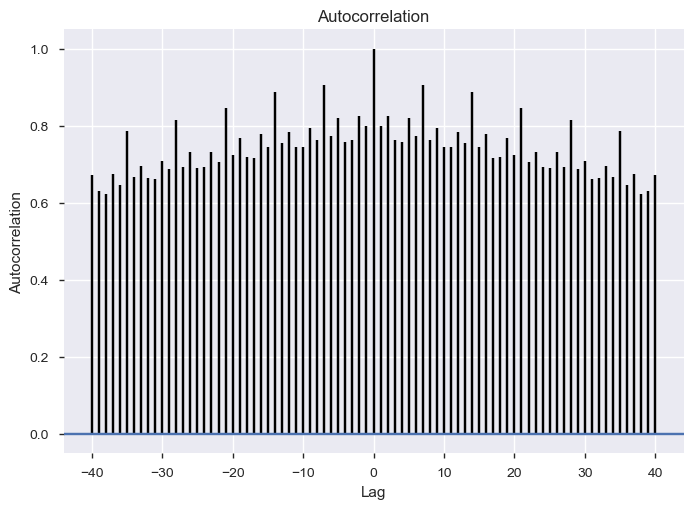

In [132]:
# Plot autocorrelation

plt.acorr(store1['unit_sales'].values, maxlags=40)

# Add labels to autocorrelation plot

plt.title('Autocorrelation')

plt.xlabel('Lag')

plt.ylabel('Autocorrelation')
# Display the autocorrelation plot

plt.show()

The cycle is 7

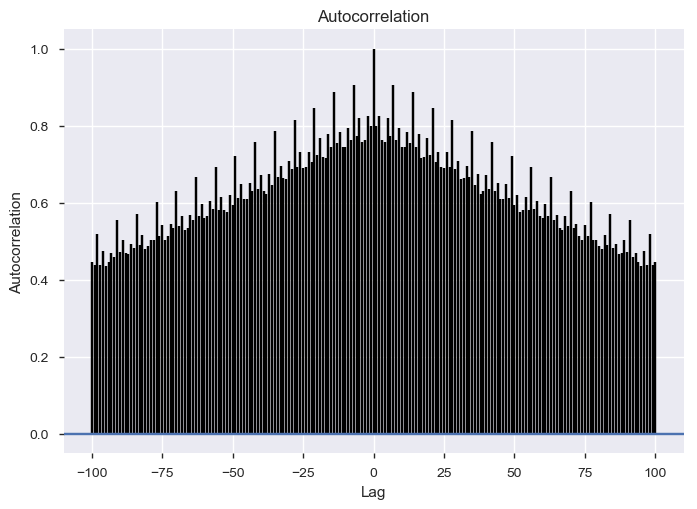

In [133]:
# Plot autocorrelation

plt.acorr(store1['unit_sales'].values, maxlags=100)

# Add labels to autocorrelation plot

plt.title('Autocorrelation')

plt.xlabel('Lag')

plt.ylabel('Autocorrelation')
# Display the autocorrelation plot

plt.show()

In [102]:
store1.corr()

,id,store_nbr,item_nbr,unit_sales,weekday
id,1.000000,NaN,NaN,0.001200,0.010809
store_nbr,NaN,NaN,NaN,NaN,NaN
item_nbr,NaN,NaN,NaN,NaN,NaN
unit_sales,0.001200,NaN,NaN,1.000000,-0.406676
weekday,0.010809,NaN,NaN,-0.406676,1.000000


## Pandas Profiling for all

In [ ]:
holidays_events_df = pd.read_csv(RAW_DATA_DIR+'holidays_events.csv')
items_df = pd.read_csv(RAW_DATA_DIR+'items.csv')
oil_df = pd.read_csv(RAW_DATA_DIR+'oil.csv')
stores_df = pd.read_csv(RAW_DATA_DIR+'stores.csv')
transactions_df = pd.read_csv(RAW_DATA_DIR+'transactions.csv')

train_df = pd.read_csv(RAW_DATA_DIR+'train.csv')

In [136]:
train_df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [140]:
items_df.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [141]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [142]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [144]:
stores_df.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [143]:
stores_df.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [145]:
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [147]:
holidays_events_df[holidays_events_df['locale']=='National']

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False


In [146]:
holidays_events_df.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [ ]:
state_events
_tmp = stores.merge()

In [ ]:
df = train_df.merge(items_df, on = 'item_nbr')
df = df.merge(oil_df, on = 'date')


In [152]:
test_df.onpromotion.unique()

array([False,  True])

In [155]:
tmp = train_df.dropna()

In [156]:
tmp.date.min()

'2014-04-01'

In [16]:
transactions_df = pd.read_csv(RAW_DATA_DIR+'transactions.csv')



In [19]:
test_df.item_nbr.unique().shape

(3902,)

In [20]:
test_df.store_nbr.unique().shape

(54,)

In [17]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
